# Classification for Stars vs. Non-Stellar Objects 


### In this notebook, we will compare `prob_star` distributions between Full Gaia Cat vs. Train Sample

- gaia `source_id`
- gaia `ra` and `dec`
- three gaia classification columns: <br> 
`classprob_dsc_combmod_star` `classprob_dsc_combmod_galaxy` `classprob_dsc_combmod_quasar`


## Import Basic Packages 

In [1]:
import numpy as np
import pandas as pd
import glob
import sys
import h5py
#from netCDF4 import Dataset
from datetime import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

import pyarrow as pa
import pyarrow.parquet as pq

from functools import reduce
import operator
import gc

# Increase display width to 200 characters
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_colwidth', 200)

In [2]:
import os

from astropy.table import Table
from matplotlib.ticker import MultipleLocator

from astropy.utils.exceptions import AstropyWarning
import warnings
warnings.simplefilter('ignore', category=AstropyWarning)

In [3]:
# plot settings
#plt.rc('font', family='serif') 
#plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'

## PySpark Session

In [4]:
%%time
# PySpark packages
from pyspark import SparkContext   
from pyspark.sql import SparkSession

import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark import Row
from pyspark.sql.window import Window as W


spark = SparkSession.builder \
    .master("yarn") \
    .appName("spark-shell") \
    .config("spark.driver.maxResultSize", "32g") \
    .config("spark.driver.memory", "32g") \
    .config("spark.executor.memory", "7g") \
    .config("spark.executor.cores", "1") \
    .config("spark.executor.instances", "200") \
    .config("spark.sql.hive.filesourcePartitionFileCacheSize", "2097152000") \
    .getOrCreate()



sc = spark.sparkContext
sc.setCheckpointDir("hdfs://spark00:54310/tmp/checkpoints")

spark.conf.set("spark.sql.debug.maxToStringFields", 500)
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

CPU times: user 12.9 ms, sys: 5.58 ms, total: 18.5 ms
Wall time: 33.1 s


> This takes time to get resources from the Yarn Cluster

## Reading Train-Labeled Sample

In [5]:
!pwd

/home/shong/work/deeplearnings/star-classification/notebook


#### Train Sample

In [6]:
datapath = '/user/shong/data/spherex/star-classification/reduced-data/'
hdfsheader = 'hdfs://spark00:54310'
localdatapath= '/home/shong/work/deeplearnings/star-classification/data/'

In [7]:
hdfsheader+datapath+'RefCat-Train-Label.parquet.snappy'

'hdfs://spark00:54310/user/shong/data/spherex/star-classification/reduced-data/RefCat-Train-Label.parquet.snappy'

In [8]:
%%time
tdf = spark.read.option("header","true").parquet(hdfsheader+datapath+'RefCat-Train-Label.parquet.snappy')

CPU times: user 2.32 ms, sys: 0 ns, total: 2.32 ms
Wall time: 2.36 s


In [9]:
tdf.printSchema()

root
 |-- Gaia_DR3_source_id: long (nullable = true)
 |-- SPHERExRefID: long (nullable = true)
 |-- LegacySurvey_uid: long (nullable = true)
 |-- PS1_DR1_StackObject_objID: long (nullable = true)
 |-- CatWISE_source_id: string (nullable = true)
 |-- AllWISE_designation: string (nullable = true)
 |-- 2MASS_designation: string (nullable = true)
 |-- ra: double (nullable = true)
 |-- dec: double (nullable = true)
 |-- ra_error: double (nullable = true)
 |-- dec_error: double (nullable = true)
 |-- coord_src: long (nullable = true)
 |-- pmra: double (nullable = true)
 |-- pmra_error: double (nullable = true)
 |-- pmdec: double (nullable = true)
 |-- pmdec_error: double (nullable = true)
 |-- parallax: double (nullable = true)
 |-- parallax_error: double (nullable = true)
 |-- ref_epoch: double (nullable = true)
 |-- astrometric_params_solved: short (nullable = true)
 |-- CatWISE_PMRA: double (nullable = true)
 |-- CatWISE_PMDec: double (nullable = true)
 |-- CatWISE_sigPMRA: double (nullab

#### Still, there are some Null labels for this catalog

In [10]:
traindf = tdf.dropna()

In [11]:
traindf.cache()

DataFrame[Gaia_DR3_source_id: bigint, SPHERExRefID: bigint, LegacySurvey_uid: bigint, PS1_DR1_StackObject_objID: bigint, CatWISE_source_id: string, AllWISE_designation: string, 2MASS_designation: string, ra: double, dec: double, ra_error: double, dec_error: double, coord_src: bigint, pmra: double, pmra_error: double, pmdec: double, pmdec_error: double, parallax: double, parallax_error: double, ref_epoch: double, astrometric_params_solved: smallint, CatWISE_PMRA: double, CatWISE_PMDec: double, CatWISE_sigPMRA: double, CatWISE_sigPMDec: double, Gaia_G: double, Gaia_BP: double, Gaia_RP: double, Gaia_G_error: double, Gaia_BP_error: double, Gaia_RP_error: double, LS_g: double, LS_r: double, LS_z: double, LS_g_error: double, LS_r_error: double, LS_z_error: double, PS1_g: double, PS1_r: double, PS1_i: double, PS1_z: double, PS1_y: double, PS1_g_error: double, PS1_r_error: double, PS1_i_error: double, PS1_z_error: double, PS1_y_error: double, 2MASS_J: double, 2MASS_H: double, 2MASS_Ks: double,

In [12]:
%%time
traindf.select(['ra','dec','gaia_classprob_dsc_combmod_star', \
                'gaia_classprob_dsc_combmod_galaxy','gaia_classprob_dsc_combmod_quasar']).describe().toPandas().T

CPU times: user 10.7 ms, sys: 2.09 ms, total: 12.8 ms
Wall time: 27 s


,0,1,2,3,4
summary,count,mean,stddev,min,max
ra,97499546,197.88838525600735,91.75315953189543,1.6327128351173464E-6,359.9999806544865
dec,97499546,15.051231911555835,27.717222646361055,-31.382798082634444,84.77074678823259
gaia_classprob_dsc_combmod_star,97499546,0.9731148012396846,0.15775595388122984,0.0,1.0
gaia_classprob_dsc_combmod_galaxy,97499546,0.013732832528726063,0.11413580298246227,0.0,1.0
gaia_classprob_dsc_combmod_quasar,97499546,0.011232709380161958,0.10144233487227099,0.0,1.0


> `97,499,546	` is our final TrainSample Size

#### Sanity Check of ra and dec between RefCat and GaiaDR3

In [13]:
traindf.select(['Gaia_DR3_source_id','ra','gaia_ra','dec','gaia_dec']).show(20,truncate=False)

+------------------+------------------+------------------+-------------------+-------------------+
|Gaia_DR3_source_id|ra                |gaia_ra           |dec                |gaia_dec           |
+------------------+------------------+------------------+-------------------+-------------------+
|7284264691456     |45.06227669197522 |45.06227669197522 |0.21600441945474147|0.21600441945474147|
|14263587225600    |45.13475778741175 |45.13475778741175 |0.3215546124504204 |0.3215546124504204 |
|72778221634816    |44.751786988531386|44.751786988531386|0.41324883067097495|0.41324883067097495|
|74594992236672    |44.72045881857565 |44.72045881857565 |0.4959731380559752 |0.4959731380559752 |
|127788162720128   |44.75591061613937 |44.75591061613937 |0.8696145483248345 |0.8696145483248345 |
|139878495490560   |44.97738333517409 |44.97738333517409 |1.133967304337373  |1.133967304337373  |
|158638912323712   |45.51570962353016 |45.51570962353016 |0.7889201098230643 |0.7889201098230643 |
|169462229

#### GaiaDR3

In [14]:
filepath = "hdfs://spark00:54310/common/data/external-catalogs/parquet/gaia-dr3/original/"

In [15]:
%%time
gaiadf = spark.read.option("header","true").option("recursiveFileLookup","true").parquet(filepath)

CPU times: user 2.32 ms, sys: 0 ns, total: 2.32 ms
Wall time: 1.72 s


In [16]:
gaiadf.printSchema()

root
 |-- solution_id: long (nullable = true)
 |-- designation: string (nullable = true)
 |-- source_id: long (nullable = true)
 |-- random_index: long (nullable = true)
 |-- ref_epoch: double (nullable = true)
 |-- ra: double (nullable = true)
 |-- ra_error: float (nullable = true)
 |-- dec: double (nullable = true)
 |-- dec_error: float (nullable = true)
 |-- parallax: double (nullable = true)
 |-- parallax_error: float (nullable = true)
 |-- parallax_over_error: float (nullable = true)
 |-- pm: float (nullable = true)
 |-- pmra: double (nullable = true)
 |-- pmra_error: float (nullable = true)
 |-- pmdec: double (nullable = true)
 |-- pmdec_error: float (nullable = true)
 |-- ra_dec_corr: float (nullable = true)
 |-- ra_parallax_corr: float (nullable = true)
 |-- ra_pmra_corr: float (nullable = true)
 |-- ra_pmdec_corr: float (nullable = true)
 |-- dec_parallax_corr: float (nullable = true)
 |-- dec_pmra_corr: float (nullable = true)
 |-- dec_pmdec_corr: float (nullable = true)
 |--

In [17]:
# We only need these columns
mycols = ['source_id','ra','dec','classprob_dsc_combmod_star',
          'classprob_dsc_combmod_galaxy','classprob_dsc_combmod_quasar']

In [18]:
gdf = gaiadf.select(mycols).dropna()

In [67]:
gdf = gdf.withColumn('sum_prob', \
                     F.col('classprob_dsc_combmod_star') + \
                     F.col('classprob_dsc_combmod_galaxy') + \
                     F.col('classprob_dsc_combmod_quasar'))

In [68]:
gdf.cache()

DataFrame[source_id: bigint, ra: double, dec: double, classprob_dsc_combmod_star: float, classprob_dsc_combmod_galaxy: float, classprob_dsc_combmod_quasar: float, sum_prob: float]

In [73]:
cols = ['source_id','classprob_dsc_combmod_star',
          'classprob_dsc_combmod_galaxy','classprob_dsc_combmod_quasar','sum_prob']

In [76]:
gdf.select(cols).show(40,truncate=True)

+-------------+--------------------------+----------------------------+----------------------------+----------+
|    source_id|classprob_dsc_combmod_star|classprob_dsc_combmod_galaxy|classprob_dsc_combmod_quasar|  sum_prob|
+-------------+--------------------------+----------------------------+----------------------------+----------+
|   4295806720|                 0.9999876|               7.0457914E-13|               3.0354892E-11| 0.9999876|
|  34361129088|                 0.9993886|                5.682676E-13|               1.0820195E-13| 0.9993886|
|  38655544960|                 0.9998059|                5.193881E-13|              1.03982646E-13| 0.9998059|
| 309238066432|                0.99997973|               5.8795424E-10|               3.4764439E-10|0.99997973|
| 343597448960|                0.99999064|                5.131301E-13|                2.770367E-11|0.99999064|
| 515396233856|                0.99999225|                 5.640497E-7|                 7.187164E-8|0.99

In [77]:
%%time
gdf.select(cols).filter(F.col('classprob_dsc_combmod_galaxy') > 0.5).show(40,truncate=True)

+---------------+--------------------------+----------------------------+----------------------------+----------+
|      source_id|classprob_dsc_combmod_star|classprob_dsc_combmod_galaxy|classprob_dsc_combmod_quasar|  sum_prob|
+---------------+--------------------------+----------------------------+----------------------------+----------+
| 18863496433408|             1.9436226E-15|                         1.0|               1.6802927E-12|       1.0|
| 20001662872192|                       0.0|                         1.0|                         0.0|       1.0|
| 20723218007680|                       0.0|                   0.9918105|                0.0081895245|       1.0|
| 22303765979008|                       0.0|                         1.0|                         0.0|       1.0|
| 22475564670080|                       0.0|                         1.0|                         0.0|       1.0|
| 24640228383104|                       0.0|                         1.0|               

In [78]:
%%time
gdf.select(cols).filter(F.col('classprob_dsc_combmod_quasar') > 0.5).show(40,truncate=True)

+---------------+--------------------------+----------------------------+----------------------------+----------+
|      source_id|classprob_dsc_combmod_star|classprob_dsc_combmod_galaxy|classprob_dsc_combmod_quasar|  sum_prob|
+---------------+--------------------------+----------------------------+----------------------------+----------+
|  9517648372480|                0.24744713|                 9.814361E-8|                  0.75255275|       1.0|
| 10655814178816|                0.25423056|                1.3117813E-7|                    0.745768| 0.9999987|
| 10892037246720|              1.0234657E-7|                1.0077936E-9|                   0.9999999|       1.0|
| 15839839588736|               9.79666E-12|               7.4936485E-10|                         1.0|       1.0|
| 19275813399552|              0.0024400912|                4.5950785E-8|                   0.9975599|       1.0|
| 22780506725760|               0.026263375|               1.1059295E-12|               

In [69]:
%%time
gdf.describe().toPandas().transpose()

CPU times: user 7.93 ms, sys: 0 ns, total: 7.93 ms
Wall time: 19.2 s


,0,1,2,3,4
summary,count,mean,stddev,min,max
source_id,1590266307,4.323867992575382E18,1.69846808056080333E18,4295806720,6917528997577384320
ra,1590266307,225.74756185711135,80.47346490956448,3.4096239126626443E-7,359.999999939548
dec,1590266307,-17.094115412363447,37.68630391712934,-89.99287859590359,89.99005196682685
classprob_dsc_combmod_star,1590266307,0.993084235549477,0.07693965045668179,0.0,1.0
classprob_dsc_combmod_galaxy,1590266307,0.002336438326887266,0.04609217115126717,0.0,1.0
classprob_dsc_combmod_quasar,1590266307,0.0036410749663895086,0.05416124999863417,0.0,1.0
sum_prob,1590266307,0.9990617472956389,0.02617318509157756,0.0,1.0000001


> Cleaned! and we got new column names for the `join` operation.

## Histograms for Gaia Labels

#### Bins

In [21]:
#tempbins = np.arange(101)/99.99
#tempbins = np.arange(101)/100.0
tempbins = np.arange(51)/50.0
print(tempbins)

[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54
 0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82
 0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.  ]


- Q: is the last bin value inclusive? $<$ or $\leq$? <br>
For safety, I use the dividend `99.99` instead of `100.0`

- For `matplotlib`, the final bin value is inclusive (i.e., closed interval).


In [22]:
pbins = tempbins.tolist()

In [23]:
leftbins = [x - 0.01 for x in pbins]

In [24]:
%%time
bins, totalstar = \
    gdf.select('classprob_dsc_combmod_star').rdd.flatMap(lambda x: x).histogram(pbins)

CPU times: user 137 ms, sys: 137 ms, total: 274 ms
Wall time: 44.3 s


In [25]:
%%time
bins, totalgalaxy = \
    gdf.select('classprob_dsc_combmod_galaxy').rdd.flatMap(lambda x: x).histogram(pbins)

CPU times: user 138 ms, sys: 129 ms, total: 267 ms
Wall time: 42.4 s


In [26]:
%%time
bins, totalquasar = \
    gdf.select('classprob_dsc_combmod_quasar').rdd.flatMap(lambda x: x).histogram(pbins)

CPU times: user 172 ms, sys: 93.7 ms, total: 266 ms
Wall time: 44 s


In [27]:
%%time
bins, trainstar = \
    traindf.select('gaia_classprob_dsc_combmod_star').rdd.flatMap(lambda x: x).histogram(pbins)

CPU times: user 19.1 ms, sys: 1.76 ms, total: 20.9 ms
Wall time: 1.72 s


In [28]:
%%time
bins, traingalaxy = \
    traindf.select('gaia_classprob_dsc_combmod_galaxy').rdd.flatMap(lambda x: x).histogram(pbins)

CPU times: user 12.8 ms, sys: 8.55 ms, total: 21.3 ms
Wall time: 1.71 s


In [29]:
%%time
bins, trainquasar = \
    traindf.select('gaia_classprob_dsc_combmod_quasar').rdd.flatMap(lambda x: x).histogram(pbins)

CPU times: user 14.1 ms, sys: 5.9 ms, total: 20 ms
Wall time: 1.71 s


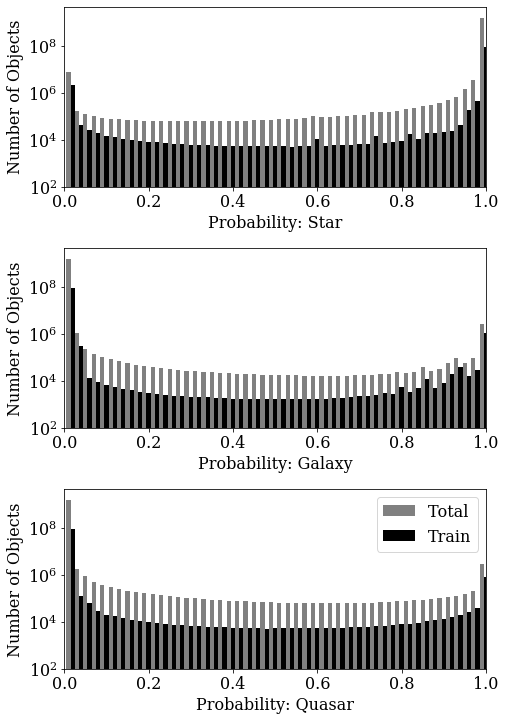

In [79]:
#plot settings
plt.rc('font', family='serif') 
#plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'

fig = plt.figure(figsize=(7,10))


plt.subplot(311)
plt.axis([0,1,1.0e2,5.0e9])
#plt.axes().set_aspect('equal', 'datalim')
#plt.title(r'Gaia_G ')
plt.xlabel(r'Probability: Star')
plt.ylabel(r'Number of Objects')
plt.yscale('log')
#plt.scatter(slicedf.px.values,slicedf.py.values,marker=".",s=1.0,color='grey')
plt.bar(leftbins[1:],totalstar,color='grey',width=0.01, label='Total')
#plt.bar(leftgbins[1:],gtraincounts,color='grey',width=400, label='Total')
plt.bar(bins[1:],trainstar,color='black',width=0.01, label='Train')

# Add legend
#plt.legend(loc=2)


plt.subplot(312)
plt.axis([0,1,1.0e2,5.0e9])
#plt.axes().set_aspect('equal', 'datalim')
#plt.title(r'Gaia_G ')
plt.xlabel(r'Probability: Galaxy')
plt.ylabel(r'Number of Objects')
plt.yscale('log')
#plt.scatter(slicedf.px.values,slicedf.py.values,marker=".",s=1.0,color='grey')
plt.bar(leftbins[1:],totalgalaxy,color='grey',width=0.01, label='Total')
#plt.bar(leftgbins[1:],gtraincounts,color='grey',width=400, label='Total')
plt.bar(bins[1:],traingalaxy,color='black',width=0.01, label='Train')

# Add legend
#plt.legend(loc=2)

plt.subplot(313)
plt.axis([0,1,1.0e2,5.0e9])
#plt.axes().set_aspect('equal', 'datalim')
#plt.title(r'Gaia_G ')
plt.xlabel(r'Probability: Quasar')
plt.ylabel(r'Number of Objects')
plt.yscale('log')
#plt.scatter(slicedf.px.values,slicedf.py.values,marker=".",s=1.0,color='grey')
plt.bar(leftbins[1:],totalquasar,color='grey',width=0.01, label='Total')
#plt.bar(leftgbins[1:],gtraincounts,color='grey',width=400, label='Total')
plt.bar(bins[1:],trainquasar,color='black',width=0.01, label='Train')

# Add legend
plt.legend(loc=1)




plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
fig.savefig("histo_gaia_label_prob.pdf")

plt.show()


## 2D Scatter Density Plot

> **This is not necessary, cuz `sum_prob == 1`**

In [31]:
# We only need these columns
gcols = ['source_id','classprob_dsc_combmod_star',
          'classprob_dsc_combmod_galaxy','classprob_dsc_combmod_quasar']

In [32]:
gbindf = gdf.withColumn("bin_star", F.floor(F.col('classprob_dsc_combmod_star') * 100)) \
            .withColumn("bin_galaxy", F.floor(F.col('classprob_dsc_combmod_galaxy') * 100)) \
            .withColumn("bin_quasar", F.floor(F.col('classprob_dsc_combmod_quasar') * 100))

In [33]:
%%time
sghisto = gbindf.groupBy('bin_star','bin_galaxy').count().toPandas()

CPU times: user 5.35 ms, sys: 1.48 ms, total: 6.83 ms
Wall time: 6.63 s


In [34]:
%%time
sqhisto = gbindf.groupBy('bin_star','bin_quasar').count().toPandas()

CPU times: user 4.52 ms, sys: 1.43 ms, total: 5.95 ms
Wall time: 4.25 s


In [40]:
%%time
gqhisto = gbindf.groupBy('bin_galaxy','bin_quasar').count().toPandas()

CPU times: user 7.53 ms, sys: 0 ns, total: 7.53 ms
Wall time: 3.95 s


In [35]:
sghisto['count'].sum()

1590266307

In [36]:
sqhisto['count'].sum()

1590266307

In [37]:
sghisto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5053 entries, 0 to 5052
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   bin_star    5053 non-null   int64
 1   bin_galaxy  5053 non-null   int64
 2   count       5053 non-null   int64
dtypes: int64(3)
memory usage: 118.6 KB


In [38]:
sghisto

,bin_star,bin_galaxy,count
0,83,16,18191
1,88,0,143291
2,3,0,55529
3,27,0,23598
4,1,94,444
...,...,...,...
5048,39,45,23
5049,12,70,14
5050,43,26,12
5051,40,35,10


In [39]:
sghisto.describe()

,bin_star,bin_galaxy,count
count,5053.000000,5053.000000,5.053000e+03
mean,33.018207,33.001979,3.147173e+05
std,23.718085,23.706456,2.184437e+07
min,0.000000,0.000000,1.000000e+00
25%,13.000000,13.000000,1.400000e+01
50%,29.000000,29.000000,2.600000e+01
75%,50.000000,50.000000,6.800000e+01
max,100.000000,100.000000,1.552731e+09


In [55]:
sghisto['count'].values

array([ 18191, 143291,  55529, ...,     12,     10,     11])

In [63]:
np.log10(10)

1.0

#### Try `imshow`, not `hist2d` with `density` arugment

In [64]:
# Create a 2D histogram array
hist_array = np.zeros((101, 101))
for x_bin, y_bin, count in zip(sghisto.bin_star.values, sghisto.bin_galaxy.values, np.log10(sghisto['count'].values)):
    hist_array[int(x_bin), int(y_bin)] = count

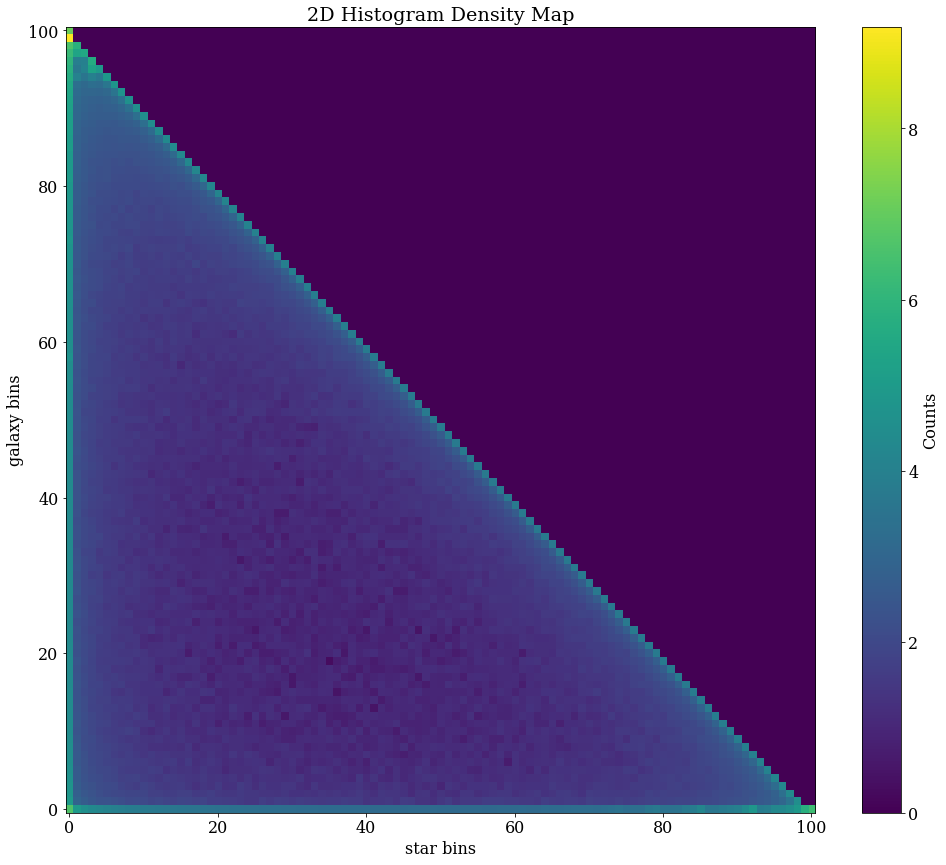

In [66]:
#plot settings
plt.rc('font', family='serif') 
#plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'

fig = plt.figure(figsize=(14,12))


#plt.subplot(131)

# Plot the 2D histogram
plt.imshow(hist_array, origin='lower', interpolation='nearest', aspect='auto')
plt.colorbar(label='Counts')
plt.xlabel('star bins')
plt.ylabel('galaxy bins')
plt.title('2D Histogram Density Map')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
fig.savefig("histo_2d_gaia_label_prob.pdf")

plt.show()